# Emotional Classification Speech Processing

In [ ]:
import os
import zipfile
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

song_path = "/content/drive/MyDrive/Audio_Dataset/Audio_Song_Actors_01-24.zip"
song_extract_to = "/content/drive/MyDrive/Audio_Dataset/Audio_Song_Actors_01-24"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully!")


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Audio_Dataset/Audio_Song_Actors_01-24"))

In [ ]:
import zipfile

speech_zip = "/content/drive/MyDrive/Audio_Dataset/Audio_Speech_Actors_01-24.zip"
speech_extract_to = "/content/drive/MyDrive/Audio_Dataset/Audio_Speech_Actors_01-24"

with zipfile.ZipFile(speech_zip, 'r') as zip_ref:
    zip_ref.extractall(speech_extract_to)

print("Speech dataset unzipped!")


## Feature Extraction and Emotions from Files

In [ ]:
# Emotion mapping
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [ ]:
def get_emotion_from_filename(filename):
    # filename format: 03-01-04-02-02-02-12.wav
    parts = filename.split("-")
    return emotion_map.get(parts[2], "unknown")

def extract_features(file_path, duration=3, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)

        # Pad or trim audio to fixed length
        target_len = duration * sr
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        features = []

        # MFCC (40)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        features.extend(np.mean(mfcc, axis=1))

        # Chroma (12)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma, axis=1))

        # Mel Spectrogram (128)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        features.extend(np.mean(mel, axis=1))

        # Spectral Contrast (7)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features.extend(np.mean(contrast, axis=1))

        # Tonnetz (6)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        features.extend(np.mean(tonnetz, axis=1))

        return np.array(features)

    except Exception as e:
        print(f"Error in {file_path}: {e}")
        return None

# -------------------------------
# Paths to both extracted folders
# -------------------------------
base_path = "/content/drive/MyDrive/Audio_Dataset"
parent_folders = ['Audio_Speech_Actors_01-24', 'Audio_Song_Actors_01-24']

X, y = [], []

for parent in parent_folders:
    folder_path = os.path.join(base_path, parent)
    print(f"Processing: {folder_path}")
    for actor_folder in os.listdir(folder_path):
        actor_path = os.path.join(folder_path, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        for file in tqdm(os.listdir(actor_path), desc=actor_folder):
            if file.endswith('.wav'):
                full_path = os.path.join(actor_path, file)
                emotion = get_emotion_from_filename(file)
                feats = extract_features(full_path)
                if feats is not None and emotion is not None:
                    X.append(feats)
                    y.append(emotion)

print("Feature extraction complete!")

# Saving as numpy array
# Convert to arrays
X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)
print("Unique emotions:", np.unique(y))

In [ ]:
sns.countplot(y)
plt.title("Emotion Class Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Preprocessing

In [306]:
# Encode text labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Label Mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i} = {label}")

Label Mapping:
0 = angry
1 = calm
2 = disgust
3 = fearful
4 = happy
5 = neutral
6 = sad
7 = surprised


In [307]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [308]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (1961, 193)
Test shape: (491, 193)


In [309]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)  # retain 98% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((1961, 87), (491, 87))

## Training Multilayer Perceptron

In [374]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# -------------------------
# Step 1: Compute class weights
# -------------------------
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

print("Class Weights Used:", class_weights)

# -------------------------
# Step 2: Build Improved Model
# -------------------------
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(8, activation='softmax')  # 8 emotion classes
])

# -------------------------
# Step 3: Compile the Model
# -------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# -------------------------
# Step 4: Add Callbacks
# -------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# -------------------------
# Step 5: Train the Model
# -------------------------
history = model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Class Weights Used: {0: np.float64(0.8580920740389179), 1: np.float64(0.8580920740389179), 2: np.float64(0.8580920740389179), 3: np.float64(0.8580920740389179), 4: np.float64(1.7219047619047618), 5: np.float64(0.8580920740389179), 6: np.float64(1.688141923436041)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.1687 - loss: 3.1227 - val_accuracy: 0.2146 - val_loss: 2.3675 - learning_rate: 5.0000e-04
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2649 - loss: 2.4478 - val_accuracy: 0.2389 - val_loss: 2.2898 - learning_rate: 5.0000e-04
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3589 - loss: 2.1219 - val_accuracy: 0.3540 - val_loss: 2.2005 - learning_rate: 5.0000e-04
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3979 - loss: 1.9542 - val_accuracy: 0.4978 - val_loss: 2.0942 - learning_rate: 5.0000e-04
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4199 - loss: 1.8566 - val_accuracy: 0.5642 - val_loss: 1.9625 - learning_rate: 5.0000e-04
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4589 - loss: 1.7603 - val_accuracy: 0.5752 - val_loss: 1.8234 - learning_rate: 5.0000e-04
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 

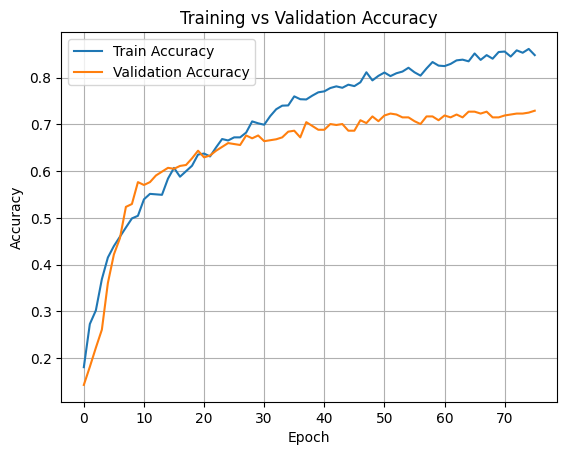

In [311]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

       angry       0.88      0.81      0.85        75
        calm       0.82      0.72      0.77        75
     disgust       0.59      0.69      0.64        39
     fearful       0.84      0.65      0.74        75
       happy       0.75      0.71      0.73        75
     neutral       0.61      0.82      0.70        38
         sad       0.65      0.68      0.66        75
   surprised       0.61      0.79      0.69        39

    accuracy                           0.73       491
   macro avg       0.72      0.73      0.72       491
weighted avg       0.74      0.73      0.73       491

F1 Score (macro): 0.7198998817388651


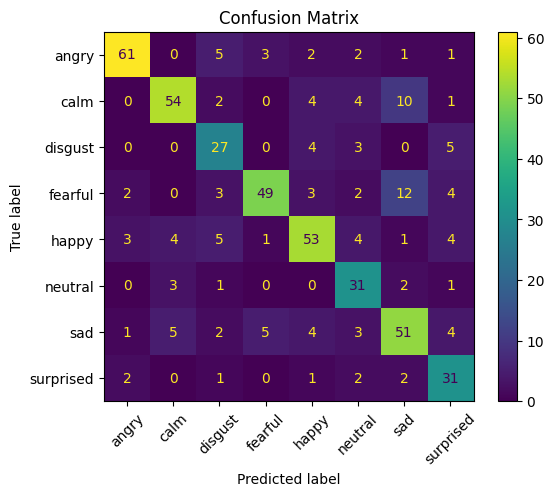

In [312]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import numpy as np

# Predict
y_pred_probs = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_probs, axis=1)

# F1 and Confusion Matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


## Dropping Emotions with Low Scores

In [313]:
# Drop unwanted emotions from dataset
unwanted_emotions = ['disgust']

X_filtered = []
y_filtered = []

for xi, yi in zip(X, y):  # or (X_pca, y)
    if yi not in unwanted_emotions:
        X_filtered.append(xi)
        y_filtered.append(yi)

X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)


In [314]:
le_ = LabelEncoder()
y_encoded = le_.fit_transform(y_filtered)

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [315]:
from sklearn.preprocessing import MinMaxScaler

# Scale before PCA
scaler_ = MinMaxScaler()
X_train_scaled = scaler_.fit_transform(X_train)
X_test_scaled = scaler_.transform(X_test)

# Apply PCA
pca_ = PCA(n_components=0.98, svd_solver='full')
X_train_pca = pca_.fit_transform(X_train_scaled)
X_test_pca = pca_.transform(X_test_scaled)


In [317]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Grid Search
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit model (on PCA data)
grid.fit(X_train_pca, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score (F1):", grid.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score (F1): 0.7687844290692089


Test Accuracy: 0.8075221238938053
Classification Report:
              precision    recall  f1-score   support

       angry       0.88      0.93      0.90        75
        calm       0.86      0.81      0.84        75
     fearful       0.76      0.83      0.79        75
       happy       0.79      0.73      0.76        75
     neutral       0.82      0.84      0.83        38
         sad       0.75      0.73      0.74        75
   surprised       0.81      0.77      0.79        39

    accuracy                           0.81       452
   macro avg       0.81      0.81      0.81       452
weighted avg       0.81      0.81      0.81       452



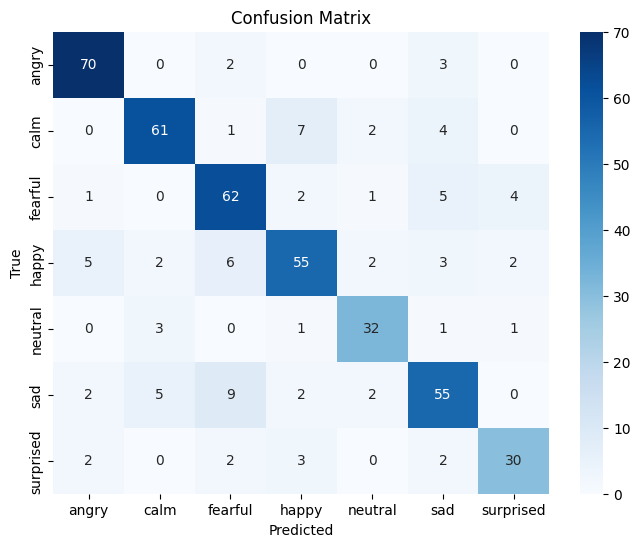

In [318]:
# Predict on test set
best_svc = grid.best_estimator_
y_pred = best_svc.predict(X_test_pca)

# Classification Report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_.classes_, yticklabels=le_.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [348]:
import joblib
import os

# Ensure the directory exists
os.makedirs("model", exist_ok=True)

# Save the trained SVC model
joblib.dump(best_svc, "model/emotion_model.pkl")

# Save the scaler, PCA, and label encoder
joblib.dump(scaler_, "model/scaler.pkl")
joblib.dump(pca_, "model/pca.pkl")
joblib.dump(le_, "model/label_encoder.pkl")

['model/label_encoder.pkl']

In [349]:
!ls /content/drive/MyDrive/Audio_Dataset/model


emotion_model.h5  emotion_model.pkl  label_encoder.pkl	pca.pkl  scaler.pkl


## predict.py

In [373]:
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model

def extract_features(file_path, duration=3, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        target_len = duration * sr
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        features = []
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        features.extend(np.mean(mfcc, axis=1))
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma, axis=1))
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        features.extend(np.mean(mel, axis=1))
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features.extend(np.mean(contrast, axis=1))
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        features.extend(np.mean(tonnetz, axis=1))
        return np.array(features)
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

def predict_emotion(file_path):
    print("🎧 Loading:", file_path)
    features = extract_features(file_path)
    if features is None:
        print("Feature extraction failed.")
        return "Error"

    scaler = joblib.load("model/scaler.pkl")
    pca = joblib.load("model/pca.pkl")
    le = joblib.load("model/label_encoder.pkl")
    model = load_model("model/emotion_model.h5")

    features_scaled = scaler.transform([features])
    features_pca = pca.transform(features_scaled)
    prediction = model.predict(features_pca)
    label = le.inverse_transform([np.argmax(prediction)])
    return label[0]


## Streamlit

### Creating app.py

In [368]:
!pip install -q streamlit pyngrok

In [369]:
app_code = """
import streamlit as st
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model
import os

scaler = joblib.load("model/scaler.pkl")
pca = joblib.load("model/pca.pkl")
label_encoder = joblib.load("model/label_encoder.pkl")

try:
    model = joblib.load("model/emotion_model.pkl")
    model_type = "sklearn"
except:
    model = load_model("model/emotion_model.h5")
    model_type = "mlp"

def extract_features(file_path, duration=3, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        target_len = duration * sr
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]
        features = []
        features.extend(np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1))
        features.extend(np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1))
        features.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1))
        features.extend(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))
        features.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1))
        return np.array(features)
    except Exception as e:
        st.error(f"Error extracting features: {e}")
        return None

st.set_page_config(page_title="🎙️ Emotion Recognition from Audio", layout="centered")
st.title("🎙️ Emotion Recognition from Audio")
st.markdown("Upload a `.wav` or `.mp3` file to predict the emotion.")

uploaded_file = st.file_uploader("Choose an audio file", type=["wav", "mp3"])

if uploaded_file is not None:
    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.read())

    st.audio("temp.wav", format="audio/wav")

    st.info("⏳ Extracting features...")
    feats = extract_features("temp.wav")

    if feats is not None:
        feats_scaled = scaler.transform([feats])
        feats_pca = pca.transform(feats_scaled)

        if model_type == "sklearn":
            pred = model.predict(feats_pca)
        else:
            pred = np.argmax(model.predict(feats_pca), axis=1)

        emotion = label_encoder.inverse_transform(pred)[0]
        st.success(f"🎯 Predicted Emotion: **{emotion.upper()}**")
"""
with open("app.py", "w") as f:
    f.write(app_code)

In [370]:
!streamlit run app.py &>/content/log.txt &

In [372]:
from pyngrok import ngrok
ngrok.set_auth_token("2z0IxB3Yj6cebgyhksPTEFCqIWZ_5PEjwrZgnGFixsXXmsc4y")  # Replace with your real token!
url = ngrok.connect(8501)
print("Streamlit App is live at:", url)

Streamlit App is live at: NgrokTunnel: "https://058d-34-19-45-180.ngrok-free.app" -> "http://localhost:8501"
